**importing libraries**

In [ ]:
! pip install yfinance


In [ ]:
! pip install finta

In [3]:
 # required library
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import datetime 

import yfinance as yf 
from finta import TA

In [4]:
# defining the parameter to extract the data
symbol= 'TSLA'
num_days=16000
INTERVAL ='1d'
# extacting the start and end data
start = str(datetime.date.today()-datetime.timedelta(num_days))
end= str(datetime.date.today())
print("start date ", start)
print("end deate ", end)

start date  1979-05-08
end deate  2023-02-26


In [5]:
# extract the data 
obj = yf.Ticker(symbol)
data=obj.history(interval=INTERVAL, start=start,end=end)
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


In [6]:
# save the data in files 
data.to_csv('abc.csv',index=False)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3187 entries, 2010-06-29 00:00:00-04:00 to 2023-02-24 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3187 non-null   float64
 1   High          3187 non-null   float64
 2   Low           3187 non-null   float64
 3   Close         3187 non-null   float64
 4   Volume        3187 non-null   int64  
 5   Dividends     3187 non-null   float64
 6   Stock Splits  3187 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 328.2 KB


In [8]:
# remove the unrequired parameters 
data.drop(['Dividends','Stock Splits'], axis=1,inplace=True)

In [9]:
data.rename(columns={"Open":"open","High":"high","Low":"low","Close":"close","Volume":"volume"}, inplace=True)

# Feature engineering 

- **RSI (Relative Strength Index):** It is a momentum indicator that compares the magnitude of recent gains to recent losses in an attempt to determine overbought and oversold conditions of an asset.

- **MACD (Moving Average Convergence Divergence):** It is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price.

- **STOCH (Stochastic Oscillator):** A momentum indicator that compares a stock's closing price to its price range over a given period of time. It is used to identify overbought or oversold conditions.

- **ADL (Accumulation/Distribution Line):** A momentum indicator that uses volume flow to assess the buying and selling pressure of a security.

- **ATR (Average True Range):** A volatility indicator that measures the range between the high and low prices of a security over a given period of time.

- **MOM (Momentum Indicator):** A momentum indicator that compares the current closing price of a security to its closing price "n" periods ago.

- **MFI (Money Flow Index):** A momentum indicator that uses both price and volume to measure buying and selling pressure.

- **ROC (Rate of Change):** A momentum indicator that measures the percentage change in price over a specified period of time.

- **OBV (On-Balance Volume):** A momentum indicator that uses volume to assess the buying and selling pressure of a security.

- **CCI (Commodity Channel Index):** A momentum indicator that measures the deviation of an asset's price from its statistical mean.

- **EMV (Ease of Movement):** A volume-based indicator that is used to assess the relationship between price and volume.

In [13]:
# list of symbol of technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV']

ewm -> Exponential smoothing is a commonly used method in time series forecasting because it can effectively capture both the short-term and long-term patterns in the data. The method works by applying a weighted average to the past observations, with more recent observations given more weight and older observations given less weight. This allows the model to capture the more recent variations in the data while also taking into account the overall trend or seasonality of the time series.

In [14]:
def indicator_data(data):
  for indicator in INDICATORS:
     # generate the indicator information for the data and
        # add the parameters with the original data
    ind_data= eval('TA.'+ indicator +'(data)')
    if not isinstance(ind_data,pd.DataFrame):
      ind_data=ind_data.to_frame()
    data=data.merge(ind_data,left_index=True,right_index=True)
  # calculating moving average for features 
  data['ema50'] = data['close'] / data['close'].ewm(50).mean()
  data['ema21'] = data['close'] / data['close'].ewm(21).mean()
  data['ema15'] = data['close'] / data['close'].ewm(14).mean()
  data['ema5'] = data['close'] / data['close'].ewm(5).mean()

  #del (data['open'])
  #del (data['high'])
  #del (data['low'])
  #del (data['volume'])
  return data
    

In [15]:
data=indicator_data(data)
data.columns

Index(['open', 'high', 'low', 'close', 'volume', '14 period RSI', 'MACD',
       'SIGNAL', '14 period STOCH %K', 'MFV', '14 period ATR', 'MOM',
       '14 period MFI', 'ROC', 'OBV', '20 period CCI', '14 period EMV.',
       'ema50', 'ema21', 'ema15', 'ema5'],
      dtype='object')

# Prepare the prediction parameter


In [16]:
def prepare_predictionn(data,window):
  
    # compare the closing price of the share on the given data
    # with the price of the share on the window
  prediction= (data.shift(-window)['close']>= data['close'])
  prediction= prediction.iloc[:-window]
  data['pred']=prediction.astype(int)
  del (data['close'])
  return data

In [17]:
data= prepare_predictionn(data, window=25)
# Remove the data parameter with null values
data=data.dropna()
data.tail()

,open,high,low,volume,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,...,14 period MFI,ROC,OBV,20 period CCI,14 period EMV.,ema50,ema21,ema15,ema5,pred
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-12 00:00:00-05:00,122.160293,124.332364,117.498634,1.729972e+08,35.734139,-14.654251,-17.073084,55.194152,1.197116e+10,8.807547,...,35.809994,-1.591476,3.240974e+10,-30.521399,-0.096050,0.631880,0.797915,0.878750,1.014063,1.0
2023-01-13 00:00:00-05:00,118.233090,123.140707,116.169589,1.782067e+08,35.433069,-13.531061,-16.364679,67.703864,1.212117e+10,8.439222,...,36.235102,7.651387,3.223153e+10,-30.041271,-0.063747,0.634218,0.802528,0.882919,1.008672,1.0
2023-01-17 00:00:00-05:00,123.459925,129.132210,122.364874,1.839959e+08,42.762490,-11.999845,-15.491712,98.781958,1.228817e+10,8.282724,...,43.529187,13.939464,3.241553e+10,13.594652,-0.027137,0.670840,0.849366,0.932281,1.049454,1.0
2023-01-18 00:00:00-05:00,132.629976,134.415658,125.616464,1.921750e+08,42.739147,-10.665645,-14.526499,81.820712,1.223470e+10,8.049484,...,51.188157,8.054218,3.222335e+10,47.613956,0.020681,0.675053,0.855044,0.936319,1.040689,1.0
2023-01-19 00:00:00-05:00,128.870994,131.317701,124.701937,1.768568e+08,41.738385,-9.589354,-13.539070,78.150571,1.221582e+10,7.899300,...,51.472465,4.650620,3.204649e+10,53.053257,0.027249,0.673472,0.853422,0.932537,1.026125,1.0


In [18]:
data.shape

(3148, 21)

#preparing the data for ml model

In [20]:
# machine learning required libraries 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [19]:
# input data 
x = data.drop('pred',axis=1)
# output data
y= data['pred']


In [21]:
# split the data into training and testing using train_test_split function 
X_train ,X_test,y_train,y_test= train_test_split(x,y,test_size=.2,random_state=21) 

In [22]:
print('Training data',X_train.shape)
print("testing data",X_test.shape)

Training data (2518, 20)
testing data (630, 20)


# Logistic Regression with hyperparmeter tunning and cross validation 

## Model training

In [24]:
# define the parameter
parameters={'max_iter':[100,200,500]}
# initialize the model 
lr_classifier=LogisticRegression()

# initialise Hyperparameter tuning and Cross validation

lr_classifier_rs= RandomizedSearchCV(estimator=lr_classifier, param_distributions=parameters , cv=5 , random_state=21,verbose=1)


In [25]:
# train the model 
lr_classifier_rs.fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'max_iter': [100, 200, 500]},
                   random_state=21, verbose=1)

In [26]:
# get best parameteres 
def get_best_parameters_result(model):
  print('Best estimator ', model.best_estimator_)
  print('Best set of parameter', model.best_params_)
  print('Best score',model.best_score_)

In [27]:
# get the best random search attributes
get_best_parameters_result(lr_classifier_rs)

Best estimator  LogisticRegression()
Best set of parameter {'max_iter': 100}
Best score 0.5734647669538325


## model prediction

In [28]:
y_pred_lr=lr_classifier_rs.predict(X_test)

## model evaluation 

In [30]:
lr_accuracy=accuracy_score(y_true=y_test,y_pred=y_pred_lr)
print('Accuracy using logistic regression ',lr_accuracy)

Accuracy using logistic regression  0.5507936507936508


In [31]:
# function to plot confusion matrix
def plot_confusion_matrix(cm,labels):
    fig, ax = plt.subplots(figsize=(6,4))
    im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
    ax.figure.colorbar(im, ax = ax)
    
    ax.set(xticks = np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=labels, yticklabels=labels,
    ylabel='True label',
    xlabel='Predicted label')
    
    thresh = cm.max() / 2.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]),ha="center", va="center",color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()

In [32]:
cm = confusion_matrix(y_test.values,y_pred_lr)
cm

array([[ 46, 215],
       [ 68, 301]])

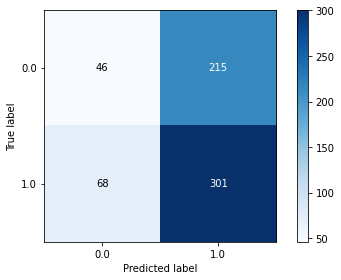

In [33]:
# cm = confusion_matrix(y_test.values,y_pred_lr)
plot_confusion_matrix(cm, np.unique(y_pred_lr))

# SVM with hyperparameter and crossvalidation 

In [34]:
parameters = {
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'C':[1.0, 2.0]
}

svm_rs = RandomizedSearchCV(estimator = SVC(), param_distributions=parameters, cv = 5, random_state = 42, verbose = 1)

In [35]:
svm_rs.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


RandomizedSearchCV(cv=5, estimator=SVC(),
                   param_distributions={'C': [1.0, 2.0],
                                        'kernel': ['rbf', 'poly', 'sigmoid']},
                   random_state=42, verbose=1)

In [37]:
# get the best random search attributes
get_best_parameters_result(svm_rs)

Best estimator  SVC(C=2.0)
Best set of parameter {'kernel': 'rbf', 'C': 2.0}
Best score 0.6247010003471236


## model prediction 

In [38]:
y_pred_svm = svm_rs.predict(X_test)

## model evaluation 

In [39]:
svm_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_svm)
print("Accuracy using Kernel SVM : ", svm_accuracy)

Accuracy using Kernel SVM :  0.6492063492063492


In [40]:
cm = confusion_matrix(y_test.values, y_pred_svm)
cm

array([[138, 123],
       [ 98, 271]])

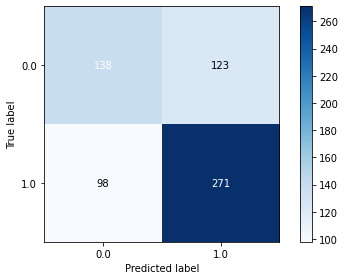

In [41]:
# cm = confusion_matrix(y_test.values,y_pred_lr)
plot_confusion_matrix(cm, np.unique(y_pred_lr))

#Decision Tree with hyperparameter and cross validation 

## model Training 

In [42]:
parameters = {'max_depth': np.arange(2, 20, 2)}

dt_classifier = DecisionTreeClassifier()
dt_classifier_rs = RandomizedSearchCV(dt_classifier, param_distributions = parameters, random_state = 42, cv = 5, verbose = 1)
dt_classifier_rs.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
                   random_state=42, verbose=1)

## model prediction 

In [43]:
y_pred_dt = dt_classifier_rs.predict(X_test)

## model evaluation 

In [44]:
dt_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_dt)
print("Accuracy using Decision tree : ", dt_accuracy)

Accuracy using Decision tree :  0.8650793650793651


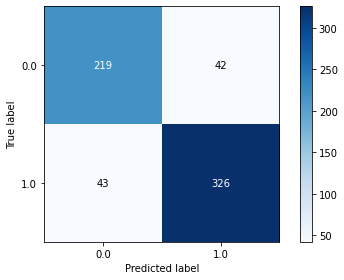

In [47]:
cm = confusion_matrix(y_test.values,y_pred_dt)
plot_confusion_matrix(cm, np.unique(y_pred_dt))

# Random forest with Hyper parameter and cross validation 

## model Training 

In [48]:
parameters = {
    'n_estimators':[110,130,140,150,160,180,200], 
    'max_depth': np.arange(2, 17, 2)
}
rf_classifier = RandomForestClassifier()
rf_classifier_rs = RandomizedSearchCV(rf_classifier, param_distributions=parameters,random_state = 42, verbose = 1, cv = 5)
rf_classifier_rs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16]),
                                        'n_estimators': [110, 130, 140, 150,
                                                         160, 180, 200]},
                   random_state=42, verbose=1)

## model prediction 

In [49]:
y_pred = rf_classifier_rs.predict(X_test)

## model evaluation 

In [50]:
rf_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy using Random forest : ", rf_accuracy)

Accuracy using Random forest :  0.9206349206349206


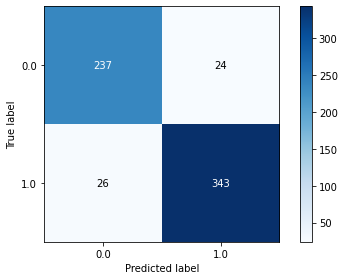

In [51]:
cm = confusion_matrix(y_test.values,y_pred)
plot_confusion_matrix(cm, np.unique(y_pred))

# Compare the model perfomance 

In [52]:
model_results = {
    'LR': lr_accuracy,
    'SVM': svm_accuracy,
    'DT': dt_accuracy,
    'RF': rf_accuracy
}

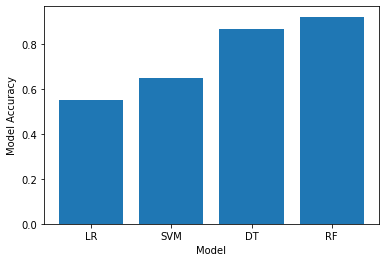

In [53]:
plt.bar(range(len(model_results)), model_results.values(), align='center')
plt.xticks(range(len(model_results)), list(model_results.keys()))
plt.ylabel("Model Accuracy")
plt.xlabel("Model")
plt.show()